In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# mask = np.load('./Data/Data/mask_4x_320_random.npy')  # Shape: (1, 320, 320)

# print("og shape:", mask.shape)

# # Use np.tile to reshape it to (1, 320, 320, 1)
# # var_sampling_mask = np.tile(var_sampling_mask[..., np.newaxis], (1, 1, 1, 1))  # Final shape: (1, 320, 320, 1)
# mask = np.tile(mask, (1, 320, 1, 2))  # tile height=320 times

# # Confirm final shape
# print("New shape:", mask.shape) 
# mask_for_plot = np.squeeze(mask[...,0])  # Shape: (320, 320)

# # Plot
# plt.figure(figsize=(5, 5))
# plt.imshow(mask_for_plot, cmap='gray')
# plt.title("Tiled Sampling Mask (320x320)")
# plt.axis('off')
# plt.show()

In [3]:
import h5py
import numpy as np
import tensorflow as tf

class MRISliceGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, batch_size=4, shuffle=True, mask=None):
        self.file_list = file_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mask = mask  # Shape: (1, 320, 320, 2)
        self.slice_index_map = []
        self._build_index()

    def _build_index(self):
        for file_idx, file_path in enumerate(self.file_list):
            with h5py.File(file_path, 'r') as f:
                num_slices = f['image_under'].shape[0]
                for slice_idx in range(num_slices):
                    self.slice_index_map.append((file_idx, slice_idx))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.slice_index_map) / self.batch_size))

    def __getitem__(self, index):
        batch_map = self.slice_index_map[index * self.batch_size:(index + 1) * self.batch_size]

        input_img_batch = []
        target_img_batch = []
        input_kspace_batch = []

        for file_idx, slice_idx in batch_map:
            with h5py.File(self.file_list[file_idx], 'r') as f:
                input_img = f['image_under'][slice_idx]       # shape: [H, W, 2]
                target_img = f['image_full'][slice_idx]       # shape: [H, W, 2]
                input_kspace = f['kspace_under'][slice_idx]   # shape: [H, W, 2]

                input_img_batch.append(input_img)
                target_img_batch.append(target_img)
                input_kspace_batch.append(input_kspace)

        x_img = np.stack(input_img_batch, axis=0)
        x_kspace = np.stack(input_kspace_batch, axis=0)
        y_batch = np.stack(target_img_batch, axis=0)

        # if self.mask is not None:
        #     actual_batch_size = len(x_img)
        #     if self.mask.shape == (1, 320, 320, 2):
        #         mask_batch = np.tile(self.mask, (actual_batch_size, 1, 1, 1))
        #     else:
        #         raise ValueError("Mask must have shape (1, 320, 320, 2)")
        #     return [x_img, mask_batch, x_kspace], y_batch
        # else:
        #     return [x_img, x_kspace], y_batch
        return x_img, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.slice_index_map)


In [4]:
train_folder = r"D:\fastmri_single_coil_FSSCAN_4x\train_sub_norm"
val_folder = r"D:\fastmri_single_coil_FSSCAN_4x\val_sub_norm"

In [5]:
import h5py
import numpy as np
import glob
import os
kspace_files_list_train = sorted(glob.glob(os.path.join(train_folder, "*.h5")))
kspace_files_list_val = sorted(glob.glob(os.path.join(val_folder, "*.h5")))

# half_train = 20
# half_val = 10
half_train = len(kspace_files_list_train) 
half_val = len(kspace_files_list_val) 
# print("half_train",half_train)
# print("half_val",half_val)
kspace_files_list_train = kspace_files_list_train[:half_train]
kspace_files_list_val = kspace_files_list_val[:half_val]

# Create generators
# train_gen = MRISliceGenerator(kspace_files_list_train,batch_size=16, shuffle=True,mask=mask)
# val_gen = MRISliceGenerator(kspace_files_list_val, batch_size=4, shuffle=False,mask=mask)
train_gen = MRISliceGenerator(kspace_files_list_train,batch_size=16, shuffle=True)
val_gen = MRISliceGenerator(kspace_files_list_val, batch_size=4, shuffle=False)

print(len(train_gen))  
print(len(val_gen))  


543
438


In [6]:
%run "C:\\Users\\DU\\aman_fastmri\\ablation_model_direct_skip.ipynb"


In [7]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

class PerpLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        # Split into real and imaginary components
        y_true_real, y_true_imag = y_true[..., 0], y_true[..., 1]
        y_pred_real, y_pred_imag = y_pred[..., 0], y_pred[..., 1]

        # Reconstruct complex tensors
        y_true_complex = tf.complex(y_true_real, y_true_imag)
        y_pred_complex = tf.complex(y_pred_real, y_pred_imag)

        # Magnitudes
        mag_pred = tf.abs(y_pred_complex)
        mag_target = tf.abs(y_true_complex)

        # Cross product magnitude
        cross = tf.abs(y_true_real * y_pred_imag - y_true_imag * y_pred_real)

        # Angle difference
        angle_true = tf.math.atan2(y_true_imag, y_true_real)
        angle_pred = tf.math.atan2(y_pred_imag, y_pred_real)
        angle_diff = angle_true - angle_pred

        # perp loss part
        ploss = cross / (mag_pred + 1e-8)
        phase = tf.math.cos(angle_diff)
        aligned_mask = tf.math.less(phase, 0.0)

        final_term = tf.where(aligned_mask,
                              mag_target + (mag_target - ploss),
                              ploss)

        # Combine with magnitude MSE
        mse_mag = tf.reduce_mean(tf.square(mag_pred - mag_target))
        total_loss = tf.reduce_mean(final_term + mse_mag)
        return total_loss




In [8]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Directory Setup ---
save_dir = "./SavedModels_ablation"
os.makedirs(save_dir, exist_ok=True)

# --- Configuration ---
H, W        = 320, 320
EPOCHS      = 20
LEARNING_RATE = 1e-4

# define checkpoint & final weight filepaths (use .h5 for weights-only)
MODEL_NAME   = os.path.join(save_dir, "model_direct_skip.h5")
WEIGHTS_FINAL = os.path.join(save_dir, "model_direct_skip.h5")


print("=" * 60)
print("🔧 TRAINING CONFIGURATION")
print("=" * 60)
print(f" Save Directory:       {save_dir}")
print(f" Model Dimensions:     {H}x{W}")
print(f" Epochs:               {EPOCHS}")
print(f" Learning Rate:        {LEARNING_RATE}")
print(f" Checkpoint Weights:   {MODEL_NAME}")
print(f" Final Weights Path:   {WEIGHTS_FINAL}")
print("=" * 60)

# --- Model Setup ---
model = build_dual_output_model()

# --- Optimizer & Compile ---
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=PerpLoss())


🔧 TRAINING CONFIGURATION
 Save Directory:       ./SavedModels_ablation
 Model Dimensions:     320x320
 Epochs:               20
 Learning Rate:        0.0001
 Checkpoint Weights:   ./SavedModels_ablation\model_direct_skip.h5
 Final Weights Path:   ./SavedModels_ablation\model_direct_skip.h5


No existing checkpoint found. Starting from scratch.

🚀 STARTING TRAINING...
Epoch 1/20
543/543 [==============================] - ETA: 0s - loss: 0.0249     
Epoch 1: val_loss improved from inf to 0.02684, saving model to ./SavedModels_ablation\model_direct_skip.h5
543/543 [==============================] - 494s 881ms/step - loss: 0.0249 - val_loss: 0.0268 - lr: 1.0000e-04
Epoch 2/20
543/543 [==============================] - ETA: 0s - loss: 0.0222  
Epoch 2: val_loss improved from 0.02684 to 0.02661, saving model to ./SavedModels_ablation\model_direct_skip.h5
543/543 [==============================] - 479s 882ms/step - loss: 0.0222 - val_loss: 0.0266 - lr: 1.0000e-04
Epoch 3/20
543/543 [==============================] - ETA: 0s - loss: 0.0219  
Epoch 3: val_loss improved from 0.02661 to 0.02626, saving model to ./SavedModels_ablation\model_direct_skip.h5
543/543 [==============================] - 477s 878ms/step - loss: 0.0219 - val_loss: 0.0263 - lr: 1.0000e-04
Epoch 4/20
543/543 [=

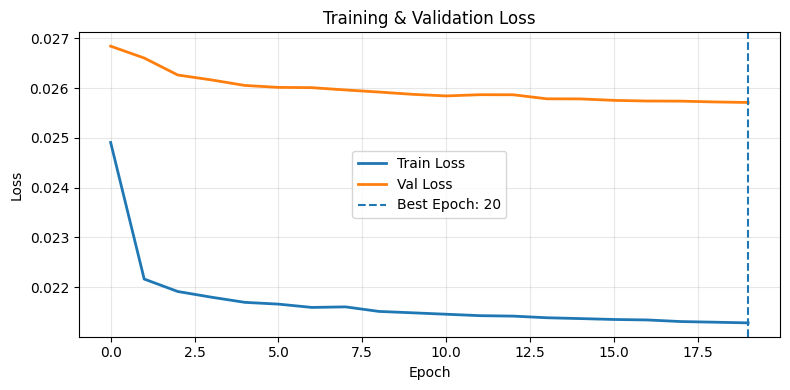

In [9]:
# # --- Optimizer & Compile ---
# optimizer = Adam(learning_rate=LEARNING_RATE)
# model.compile(optimizer=optimizer, loss=PerpLoss())

# --- Load Existing Best Weights ---
if os.path.isfile(MODEL_NAME):
    try:
        model.load_weights(MODEL_NAME)
        print(f"Loaded checkpoint weights from {MODEL_NAME}")
    except Exception as e:
        print(f" Could not load checkpoint: {e}\n   Starting from scratch.")
else:
    print("No existing checkpoint found. Starting from scratch.")

# --- Callbacks ---
checkpoint_cb = ModelCheckpoint(
    filepath=MODEL_NAME,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=20,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1,
    mode="min"
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# --- Training ---
print("\n🚀 STARTING TRAINING...")
print("=" * 60)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
print("\n TRAINING COMPLETED")

# --- Save Final Weights ---
model.save_weights(WEIGHTS_FINAL)
print(f" Final weights saved to {WEIGHTS_FINAL}")

# --- Verify Checkpoints on Disk ---
# print("\n Contents of checkpoint directory:")
# for f in sorted(glob.glob(os.path.join(save_dir, "*.h5"))):
#     print("   ", f)

# --- Training Analysis ---
if history:
    print("\n TRAINING ANALYSIS")
    print("=" * 60)
    best_epoch     = np.argmin(history.history["val_loss"]) + 1
    best_val_loss  = np.min(history.history["val_loss"])
    final_train    = history.history["loss"][-1]
    final_val      = history.history["val_loss"][-1]

    print(f" Best Epoch:           {best_epoch}")
    print(f" Best Validation Loss: {best_val_loss:.6f}")
    print(f" Final Training Loss:  {final_train:.6f}")
    print(f" Final Validation Loss:{final_val:.6f}")

# --- Plot Training Curves ---
def plot_training_history(hist):
    plt.figure(figsize=(8, 4))
    plt.plot(hist["loss"],     label="Train Loss", linewidth=2)
    plt.plot(hist["val_loss"], label="Val Loss",   linewidth=2)
    best_ep = int(np.argmin(hist["val_loss"]))
    plt.axvline(best_ep, linestyle="--", label=f"Best Epoch: {best_ep+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

if history:
    plot_training_history(history.history)


In [10]:
import os
print("📂 Current Working Directory:", os.getcwd())


📂 Current Working Directory: C:\Users\DU\aman_fastmri


In [11]:
import os
import numpy as np
import h5py
import glob
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Path to validation folder
# val_folder = "F:/denoised_preprocessed_h5_val"

val_folder = r"E:\fastmri\val_norm"
# val_folder = r"D:\val_norm"

# val_folder = r"G:\val_norm\val_norm"
# files = sorted([os.path.join(val_folder, f) for f in os.listdir(val_folder) if f.endswith(".h5")])
kspace_files_list_val = sorted(glob.glob(os.path.join(val_folder, "*.h5")))
file_paths = kspace_files_list_val


# ----------------------
# HELPERS
# ----------------------
def to_complex(x):
    return x[..., 0] + 1j * x[..., 1]

def nmse(gt, pred):
    return np.linalg.norm(gt - pred) ** 2 / (np.linalg.norm(gt) ** 2 + 1e-10)

def compute_ssim(gt, pred, max_val):
    return structural_similarity(
        gt, pred,
        data_range=max_val,
        win_size=9,
        gaussian_weights=False,
        use_sample_covariance=False,
        K1=0.01,
        K2=0.03
    )

# ----------------------
# STORAGE
# ----------------------
ssim_list = []
psnr_list = []
nmse_list = []

# ----------------------
# PROCESSING
# ----------------------
for file in tqdm(file_paths, desc="Processing volumes"):
    with h5py.File(file, 'r') as f:
        image_full = f["image_full"][:]       # (slices, H, W, 2)
        image_under = f["image_under"][:]     # (slices, H, W, 2)
        max_val = float(f["max_val_full_image"][0])

#     mask_batch = np.tile(mask, (image_under.shape[0], 1, 1, 1)) 
    # Get model prediction (still in normalized form)
    # pred = model.predict([image_under,mask_batch,image_under], verbose=0)  # shape (slices, H, W, 2)
    pred = model.predict(image_under, verbose=0)  # shape (slices, H, W, 2)
    
    image_full *= max_val
    
    pred *= max_val  # Scale predicted output to original intensity range

    # Convert to complex and get magnitude
    gt_mag = np.abs(to_complex(image_full))
    pred_mag = np.abs(to_complex(pred))

    # Volume-wise PSNR and NMSE
    psnr_val = peak_signal_noise_ratio(gt_mag, pred_mag, data_range=max_val)
    nmse_val = nmse(gt_mag.flatten(), pred_mag.flatten())

    psnr_list.append(psnr_val)
    nmse_list.append(nmse_val)

    # Slice-wise SSIM
    for i in range(gt_mag.shape[0]):
        ssim_val = compute_ssim(gt_mag[i], pred_mag[i], max_val)
        ssim_list.append(ssim_val)

# ----------------------
# REPORT
# ----------------------
print("\n" + "=" * 40)
print(f"PSNR (Mag, volume): {np.mean(psnr_list):.2f} ± {np.std(psnr_list):.2f} dB")
print(f"NMSE (Mag, volume): {np.mean(nmse_list):.6f} ± {np.std(nmse_list):.6f}")
print(f"SSIM (Mag, slice):  {np.mean(ssim_list):.4f} ± {np.std(ssim_list):.4f}")

print("=" * 40)


Processing volumes: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.14s/it]


PSNR (Mag, volume): 32.17 ± 2.02 dB
NMSE (Mag, volume): 0.025805 ± 0.012504
SSIM (Mag, slice):  0.7507 ± 0.0888


In [14]:
import os
import numpy as np
import h5py
import glob
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Path to validation folder
# val_folder = "F:/denoised_preprocessed_h5_val"

# val_folder = r"E:\fastmri\val_norm"
# val_folder = r"D:\val_norm"
model.load_weights(".\SavedModels_ablation\model_direct_skip.h5")


# val_folder = r"G:\val_norm\val_norm"
# files = sorted([os.path.join(val_folder, f) for f in os.listdir(val_folder) if f.endswith(".h5")])
kspace_files_list_val = sorted(glob.glob(os.path.join(val_folder, "*.h5")))
file_paths = kspace_files_list_val


# ----------------------
# HELPERS
# ----------------------
def to_complex(x):
    return x[..., 0] + 1j * x[..., 1]

def nmse(gt, pred):
    return np.linalg.norm(gt - pred) ** 2 / (np.linalg.norm(gt) ** 2 + 1e-10)

def compute_ssim(gt, pred, max_val):
    return structural_similarity(
        gt, pred,
        data_range=max_val,
        win_size=9,
        gaussian_weights=False,
        use_sample_covariance=False,
        K1=0.01,
        K2=0.03
    )

# ----------------------
# STORAGE
# ----------------------
ssim_list = []
psnr_list = []
nmse_list = []

# ----------------------
# PROCESSING
# ----------------------
for file in tqdm(file_paths, desc="Processing volumes"):
    with h5py.File(file, 'r') as f:
        image_full = f["image_full"][:]       # (slices, H, W, 2)
        image_under = f["image_under"][:]     # (slices, H, W, 2)
        max_val = float(f["max_val_full_image"][0])

#     mask_batch = np.tile(mask, (image_under.shape[0], 1, 1, 1)) 
    # Get model prediction (still in normalized form)
    # pred = model.predict([image_under,mask_batch,image_under], verbose=0)  # shape (slices, H, W, 2)
    #pred = model.predict(image_under, verbose=0)  # shape (slices, H, W, 2)
    
    image_full *= max_val
    
    image_under *= max_val  # Scale predicted output to original intensity range

    # Convert to complex and get magnitude
    gt_mag = np.abs(to_complex(image_full))
    pred_mag = np.abs(to_complex(image_under))

    # Volume-wise PSNR and NMSE
    psnr_val = peak_signal_noise_ratio(gt_mag, pred_mag, data_range=max_val)
    nmse_val = nmse(gt_mag.flatten(), pred_mag.flatten())

    psnr_list.append(psnr_val)
    nmse_list.append(nmse_val)

    # Slice-wise SSIM
    for i in range(gt_mag.shape[0]):
        ssim_val = compute_ssim(gt_mag[i], pred_mag[i], max_val)
        ssim_list.append(ssim_val)

# ----------------------
# REPORT
# ----------------------
print("\n" + "=" * 40)
print(f"PSNR (Mag, volume): {np.mean(psnr_list):.2f} ± {np.std(psnr_list):.2f} dB")
print(f"NMSE (Mag, volume): {np.mean(nmse_list):.6f} ± {np.std(nmse_list):.6f}")
print(f"SSIM (Mag, slice):  {np.mean(ssim_list):.4f} ± {np.std(ssim_list):.4f}")
print("=" * 40)

Processing volumes: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.70it/s]


PSNR (Mag, volume): 30.05 ± 1.84 dB
NMSE (Mag, volume): 0.040689 ± 0.017506
SSIM (Mag, slice):  0.7059 ± 0.0772
